In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-sam/dog 1.jpg


In [4]:
# Install required packages
!pip install -q transformers opencv-python timm
!pip install -q git+https://github.com/facebookresearch/segment-anything-2.git
print("✓ Installation complete!")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.4 MB/s eta 0:00:00
✓ Installation complete!


In [5]:
# Download SAM2 model weights
import os

if not os.path.exists('sam2_hiera_base_plus.pt'):
    !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt
    print("✓ SAM2 checkpoint downloaded")
else:
    print("✓ Checkpoint already exists")

✓ Checkpoint already exists


In [6]:
# Import all necessary libraries
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import cv2
import os

# SAM2 imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

print("✓ All libraries imported successfully")

2025-10-04 18:45:00.064876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759603500.226910     233 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759603500.273526     233 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ All libraries imported successfully


In [7]:
# Setup device and configurations
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Using device: {device}")

# Settings
text_prompt = "dog"  # ← Change this to segment different objects
threshold = 0.4      # CLIPSeg mask threshold

print(f"📝 Text prompt: '{text_prompt}'")
print(f"🎯 Threshold: {threshold}")

🖥️ Using device: cuda
📝 Text prompt: 'dog'
🎯 Threshold: 0.4


In [8]:
# If you added dataset to your notebook:
# 1. Click "+ Add Data" → Upload Dataset
# 2. Upload your image, then use:

image_path = "/kaggle/input/image-sam/dog 1.jpg"  # ← Update this path
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

print(f"✓ Image loaded: {image_np.shape}")

✓ Image loaded: (860, 1280, 3)


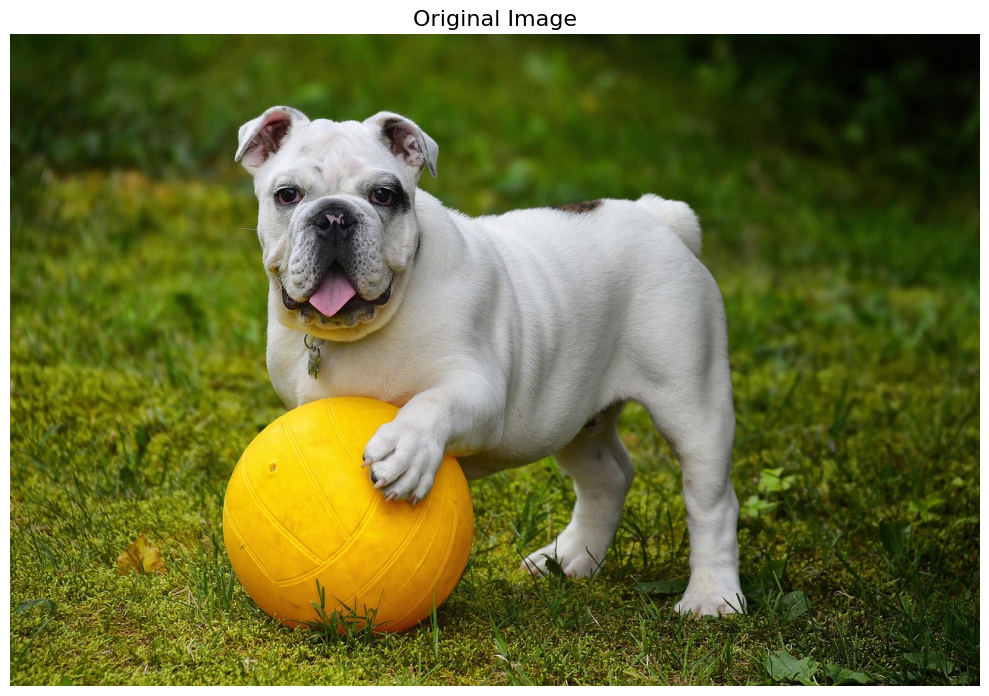

In [9]:
# Visualize the input image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Original Image", fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
# Load CLIPSeg for text-based segmentation
print("Loading CLIPSeg model...")

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
).to(device)

print("✓ CLIPSeg model loaded")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading CLIPSeg model...


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/603M [00:00<?, ?B/s]

✓ CLIPSeg model loaded


In [11]:
# Generate coarse mask using text prompt
print(f"Running CLIPSeg for: '{text_prompt}'...")

inputs = processor(
    text=[text_prompt], 
    images=image, 
    return_tensors="pt",
    padding=True
).to(device)

with torch.no_grad():
    outputs = clipseg_model(**inputs)

# Get mask and resize to image dimensions
mask_coarse = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
mask_coarse_resized = cv2.resize(
    mask_coarse, 
    (image_np.shape[1], image_np.shape[0])
)

print(f"✓ CLIPSeg mask generated: {mask_coarse_resized.shape}")

Running CLIPSeg for: 'dog'...


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


✓ CLIPSeg mask generated: (860, 1280)


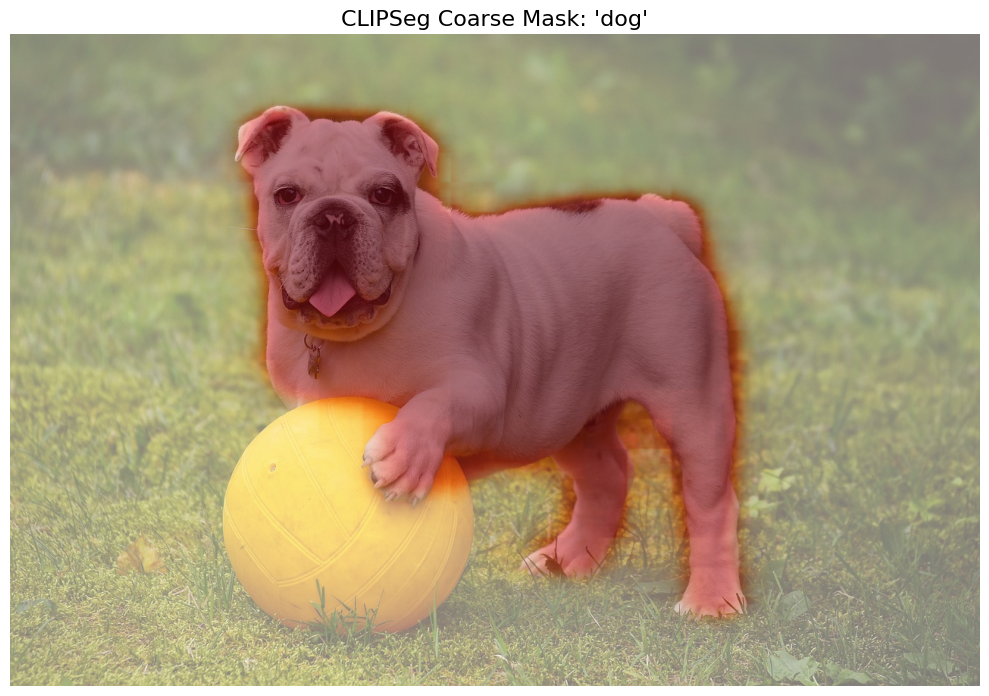

Mask value range: [0.000, 0.981]
Pixels above threshold (0.4): 269032


In [12]:
# Display CLIPSeg result
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.imshow(mask_coarse_resized, alpha=0.5, cmap="Reds")
plt.axis("off")
plt.title(f"CLIPSeg Coarse Mask: '{text_prompt}'", fontsize=16)
plt.tight_layout()
plt.show()

# Show mask statistics
print(f"Mask value range: [{mask_coarse_resized.min():.3f}, {mask_coarse_resized.max():.3f}]")
print(f"Pixels above threshold ({threshold}): {(mask_coarse_resized > threshold).sum()}")


In [13]:
# Extract bounding box from CLIPSeg mask
binary_mask = mask_coarse_resized > threshold
y, x = np.where(binary_mask)

if len(x) == 0 or len(y) == 0:
    print("⚠️ No object detected! Using full image as fallback.")
    input_box = np.array([0, 0, image_np.shape[1]-1, image_np.shape[0]-1])
else:
    input_box = np.array([min(x), min(y), max(x), max(y)])
    print(f"✓ Bounding box extracted: {input_box}")
    
    # Calculate box dimensions
    width = input_box[2] - input_box[0]
    height = input_box[3] - input_box[1]
    print(f"  Box size: {width}x{height} pixels")

✓ Bounding box extracted: [301  97 968 767]
  Box size: 667x670 pixels


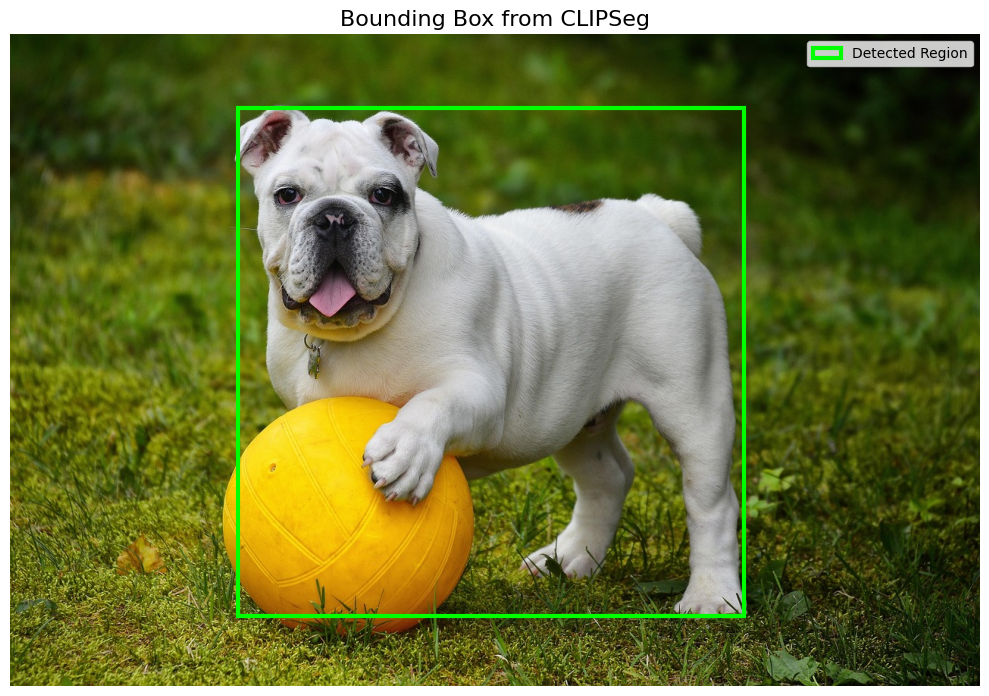

In [14]:
# Display detected bounding box
plt.figure(figsize=(10, 8))
plt.imshow(image)

# Draw rectangle
rect = plt.Rectangle(
    (input_box[0], input_box[1]),
    input_box[2] - input_box[0],
    input_box[3] - input_box[1],
    linewidth=3,
    edgecolor='lime',
    facecolor='none',
    label='Detected Region'
)
plt.gca().add_patch(rect)
plt.axis("off")
plt.title("Bounding Box from CLIPSeg", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Initialize SAM2 for refined segmentation
print("Loading SAM2 model...")

sam2_checkpoint = "sam2_hiera_base_plus.pt"
model_cfg = "sam2_hiera_b+.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

print("✓ SAM2 model loaded")

Loading SAM2 model...
✓ SAM2 model loaded


In [16]:
# Generate refined segmentation mask
print("Running SAM2 refinement...")

predictor.set_image(image_np)

# Predict with bounding box prompt
masks, scores, logits = predictor.predict(
    box=input_box[None, :],
    multimask_output=True
)

# Select best mask based on confidence score
best_idx = np.argmax(scores)
mask_refined = masks[best_idx]

print(f"✓ SAM2 generated {len(masks)} masks")
print(f"✓ Selected mask #{best_idx} with score: {scores[best_idx]:.4f}")
print(f"  Mask covers {mask_refined.sum() / mask_refined.size * 100:.2f}% of image")

Running SAM2 refinement...
✓ SAM2 generated 3 masks
✓ Selected mask #2 with score: 0.9917
  Mask covers 22.24% of image


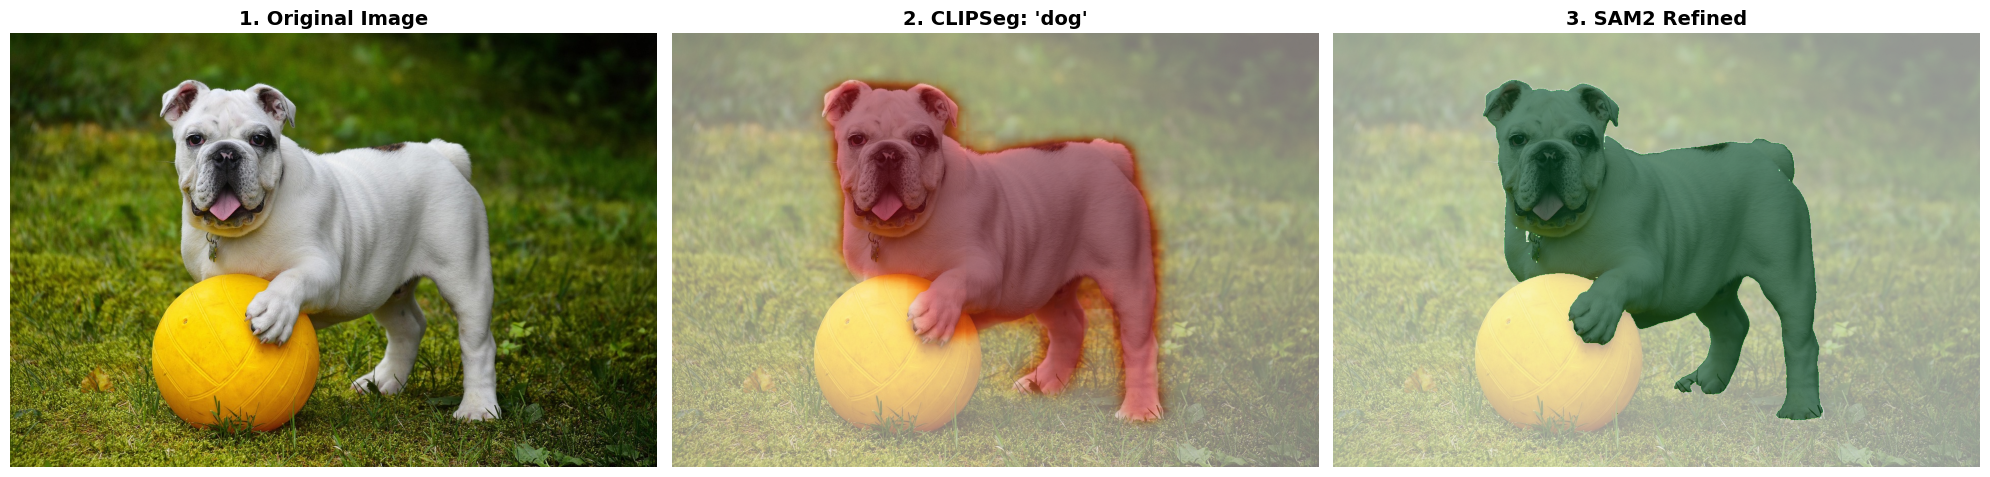

In [17]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original Image
axes[0].imshow(image)
axes[0].set_title("1. Original Image", fontsize=14, fontweight='bold')
axes[0].axis("off")

# CLIPSeg Coarse Mask
axes[1].imshow(image)
axes[1].imshow(mask_coarse_resized, alpha=0.5, cmap="Reds")
axes[1].set_title(f"2. CLIPSeg: '{text_prompt}'", fontsize=14, fontweight='bold')
axes[1].axis("off")

# SAM2 Refined Mask
axes[2].imshow(image)
axes[2].imshow(mask_refined, alpha=0.6, cmap="Greens")
axes[2].set_title("3. SAM2 Refined", fontsize=14, fontweight='bold')
axes[2].axis("off")

plt.tight_layout()
plt.show()

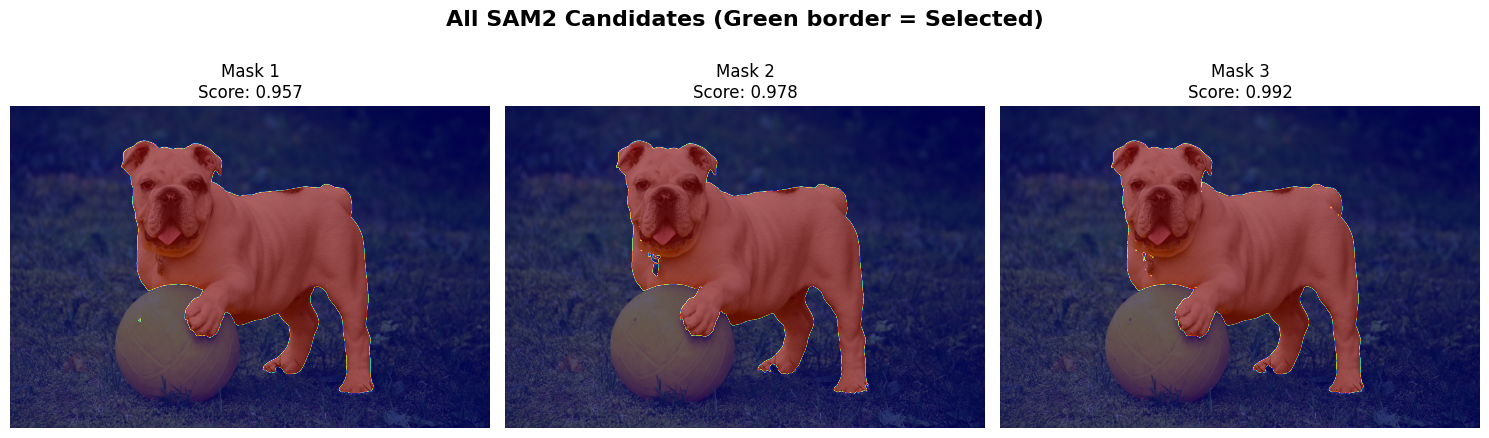

In [18]:
# Show all SAM2 candidate masks
fig, axes = plt.subplots(1, len(masks), figsize=(5*len(masks), 5))

if len(masks) == 1:
    axes = [axes]

for i, (mask, score) in enumerate(zip(masks, scores)):
    axes[i].imshow(image)
    axes[i].imshow(mask, alpha=0.6, cmap="jet")
    axes[i].set_title(f"Mask {i+1}\nScore: {score:.3f}", fontsize=12)
    axes[i].axis("off")
    
    if i == best_idx:
        for spine in axes[i].spines.values():
            spine.set_edgecolor('lime')
            spine.set_linewidth(4)

plt.suptitle("All SAM2 Candidates (Green border = Selected)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()